In [8]:
import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict, deque
import math, random
import heapq
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
from numba import njit
from typing import Tuple, Dict, List, Set, Sequence, Union
import itertools
from typing import Any

# 0. Component Sampling EPC

In [12]:
def sigma_exact(
    G: nx.Graph,
    S: set,
    use_tqdm: bool = False
) -> int:
    from itertools import product
    edges = list(G.edges())
    total_conn = 0.0

    for state in product([0,1], repeat=len(edges)):
        p_state = 1
        Gp = nx.Graph()
        Gp.add_nodes_from(set(G.nodes())-S)

        for (e, keep) in zip(edges, state):
            p_edge = G.edges[e]['p']
            p_state *= (p_edge if keep else (1-p_edge))

            if keep and e[0] not in S and e[1] not in S:
                Gp.add_edge(*e)

        # count connected i<j pairs in Gp−S
        for i,j in combinations(set(G.nodes())-S, 2):
            if nx.has_path(Gp, i, j):
                total_conn += p_state

    return total_conn

In [13]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

# 1. Greedy+EPC optimized

In [14]:
import math
import heapq
from typing import Tuple, Dict, List, Set

import networkx as nx
import numpy as np
from numba import njit, prange

def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr `'p'`) to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     for u in nodes:
         for v in G.neighbors(u):
             indices.append(idx_of[v])
             probs.append(G.edges[u, v]['p'])
         indptr.append(len(indices))

     return (
         nodes,
         idx_of,
         np.asarray(indptr, dtype=np.int32),
         np.asarray(indices, dtype=np.int32),
         np.asarray(probs, dtype=np.float32),
     )

@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:  # edge absent
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1

@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        u = surv[np.random.randint(m)]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)

    return (m * acc) / (2.0 * num_samples)

from typing import Tuple, Dict, List, Set, Sequence, Union

def greedy_cndp_epc_celf(
    G: nx.Graph,
    K: int,
    *,
    num_samples: int = 20_000,
    reuse_csr: Tuple = None,
    return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    """Select **K** nodes that minimise EPC using CELF & Numba.

    Parameters
    ----------
    return_trace : bool, default *False*
        If *True*, also return a list `[σ(S₁), σ(S₂), …]` where `S_i` is the
        prefix after deleting *i* nodes.  Useful for plots.
    """

    # CSR cache --------------------------------------------------------
    if reuse_csr is None:
        nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    else:
        nodes, idx_of, indptr, indices, probs = reuse_csr
    n = len(nodes)

    deleted = np.zeros(n, dtype=np.bool_)
    current_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    pq: List[Tuple[float, int, int]] = []  # (-gain, v, last_round)
    gains = np.empty(n, dtype=np.float32)

    for v in range(n):
        deleted[v] = True
        gains[v] = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
        deleted[v] = False
        heapq.heappush(pq, (-gains[v], v, 0))

    S: Set[int] = set()
    trace: List[float] = []
    round_ = 0

    trace.append(current_sigma)

    while len(S) < K and pq:
        neg_gain, v, last = heapq.heappop(pq)
        if last == round_:
            # gain up‑to‑date → accept
            S.add(nodes[v])
            deleted[v] = True
            current_sigma += neg_gain  # add neg (= subtract gain)
            round_ += 1
            if return_trace:
                trace.append(current_sigma)
        else:
            # recompute gain lazily
            deleted[v] = True
            new_gain = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
            deleted[v] = False
            heapq.heappush(pq, (-new_gain, v, round_))

    return (S, trace) if return_trace else S

def optimise_epc(
     G: nx.Graph,
     K: int,
     *,
     num_samples: int = 20_000,
     return_trace: bool = False,
 ) -> Union[Set[int], Tuple[Set[int], List[float]]]:
     csr = nx_to_csr(G)
     return greedy_cndp_epc_celf(G, K, num_samples=num_samples, reuse_csr=csr, return_trace=return_trace)

# 2. Greedy+EPC (non-optimized)

In [15]:
def greedy_cndp_epc(
    G: nx.Graph,
    K: int,
    num_samples: int = 10000,
    exact: bool = False,
    use_tqdm: bool = False
) -> set:
  """
  Algorithm 2 from the paper: Greedy selection of S |S| <= K
  to minimize sigma(S) via sigma_monte_carlo().

  Returns the list S (in pick order).
  """

  # S <= {Empty set} init
  S = set()

  Sigma_delta = []
  # Current sigma(S) for the empty set
  sigma_S = 0
  if exact:
    sigma_S = sigma_exact(G, S)
  else:
    sigma_S = component_sampling_epc_mc(G, S, num_samples=num_samples)

  Sigma_delta.append(sigma_S)
  # print(f"Initial sigma(S): {sigma_S}")

  if use_tqdm:
    it = tqdm(range(K), desc='Greedy selection', total=K)
  else:
    it = range(K)

  # Greedily select K nodes
  for _ in it:
    # inits
    best_j = None
    best_gain = -float('inf')
    best_sigma = None

    # find v maximizing gain sigma(S) - sigma(S ∪ j)
    for j in G:
      # Skip if j is already in S to avoid redundant calculations
      # j ∈ S
      if j in S:
        continue

      # S ∪ j = S + {j}
      if exact:
        sigma_Sj = sigma_exact(G, S | {j})
      else:
        sigma_Sj = component_sampling_epc_mc(G, S | {j}, num_samples=num_samples)

      gain = sigma_S - sigma_Sj

      # j <= argmax_{j ∈ V\S} (sigma(S) - sigma(S ∪ j))

      if gain > best_gain:
        best_gain = gain
        best_j = j
        best_sigma = sigma_Sj


    # add the best node
    if best_j is None:
      break

    S.add(best_j)
    sigma_S = best_sigma

    Sigma_delta.append(best_sigma)
    # print(f"Selected node {best_j}, gain: {best_gain}, new sigma(S): {sigma_S}")

  return S, Sigma_delta

# 3. Betweenness, PageRank, Degree-based

In [16]:
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
  bc = nx.betweenness_centrality(G)
  topk = sorted(bc, key=bc.get, reverse=True)[:k]
  H = G.copy()
  H.remove_nodes_from(topk)
  return H

# def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
#   L = nx.line_graph(G)
#   pr = nx.pagerank(L)
#   topk = sorted(pr, key=pr.get, reverse=True)[:k]
#   H = G.copy()
#   H.remove_edges_from(topk)
#   return H

def remove_k_pagerank_nodes(
    G: nx.Graph,
    k: int,
    *,
    pagerank_kwargs: Dict[str, Any] | None = None,
) -> nx.Graph:
    """
    Return a copy of *G* after deleting the k nodes with the
    highest PageRank scores.

    Parameters
    ----------
    G : nx.Graph
        Input graph (directed or undirected).
    k : int
        Number of nodes to delete.
    pagerank_kwargs : dict, optional
        Extra keyword arguments forwarded to ``nx.pagerank``;
        e.g. ``alpha=0.85``, ``weight="weight"``, ``max_iter=100`` …
        Leave empty to accept NetworkX defaults.

    Notes
    -----
    * On an **undirected** graph, PageRank reduces to a
      normalized eigenvector centrality, so the ranking you get is
      equivalent to “importance” in many other centrality measures.
    * If your graph already stores an edge‐probability attribute
      (e.g. ``'p'`` from your EPC experiments), you usually **don’t**
      want to feed that into PageRank as a weight—leave ``weight=None``.
      Otherwise high-probability *missing* edges distort the walk.
    """
    pagerank_kwargs = {} if pagerank_kwargs is None else dict(pagerank_kwargs)

    # 1. Compute PR on the node set
    pr = nx.pagerank(G, **pagerank_kwargs)

    # 2. Pick the k nodes with largest score
    topk = sorted(pr, key=pr.get, reverse=True)[:k]

    # 3. Remove and return a fresh graph
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_degree_centrality(G: nx.Graph, k: int) -> nx.Graph:
    """
    Remove the k nodes with highest *degree centrality*, 
    i.e. degree/(n−1).  Ranks identically to raw degree.
    """
    dc = nx.degree_centrality(G)             # {node: centrality}
    topk = sorted(dc, key=dc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

# 4. REGA with LP

In [17]:
def solve_lp_relaxation(G: nx.Graph, D: set, k: int) -> dict:
  nodes = list(G.nodes())
  n = len(nodes)
  edges = list(G.edges())
  m = len(edges)

  idx_s = {nodes[i]: i for i in range(n)}
  idx_z = {edges[j]: n + j for j in range(m)}

  bounds = [(0,1)] * (n + m)
  for u in D:
      bounds[idx_s[u]] = (1,1)

  A_eq = np.zeros((1, n + m))
  for u in nodes:
      A_eq[0, idx_s[u]] = 1
  b_eq = [k]

  A_ub, b_ub = [], []
  for (u, v) in edges:
      iu, iv = idx_s[u], idx_s[v]
      iz = idx_z[(u, v)]
      row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
      A_ub.append(row); b_ub.append(1)
      row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
      A_ub.append(row); b_ub.append(1)
      row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
      A_ub.append(row); b_ub.append(-1)
  A_ub = np.array(A_ub); b_ub = np.array(b_ub)

  c = np.zeros(n + m)
  for j, (u, v) in enumerate(edges):
      c[n + j] = G.edges[u, v]['p']

  res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                bounds=bounds, method='highs')
  if not res.success:
      raise RuntimeError("LP infeasible: " + res.message)
  return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G: nx.Graph, k: int, R: int, alpha: float) -> set:
  best_S, best_obj = None, float('inf')
  nodes = set(G.nodes())

  for _ in range(R):
      D = set()
      for _ in range(k):
          s_vals = solve_lp_relaxation(G, D, k)
          rem = list(nodes - D)
          sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
          m = max(1, int(alpha * len(sorted_nodes)))
          D.add(random.choice(sorted_nodes[:m]))
      current_obj = component_sampling_epc_mc(G, D, 1000)
      improved = True
      while improved:
          improved = False
          for u in list(D):
              for v in nodes - D:
                  newS = (D - {u}) | {v}
                  val = component_sampling_epc_mc(G, newS, 1000)
                  if val < current_obj:
                      D, current_obj, improved = newS, val, True
                      break
              if improved:
                  break
      if current_obj < best_obj:
          best_S, best_obj = D.copy(), current_obj
  return best_S

# 5. Greedy from MIS

In [32]:
def greedy_epc_mis(G, k, num_samples):

  # Maximal independent set
  MIS = nx.maximal_independent_set(G)
  R = set(MIS)
  target = len(G) - k
  V = G.number_of_nodes()

  sigma_delta = []

  # print(f"#MIS: {len(R)}")

  # Greedy grow R set until |R| = |V| - k
  while len(R) < target:
    best_j, best_sigma = None, float('inf')
    for j in G.nodes():
      if j in R:
        continue

      # delete node
      S_j = set(G.nodes()) - (R | {j})
      sigma = component_sampling_epc_mc(G, S=S_j, num_samples=num_samples)

      if sigma < best_sigma:
        best_sigma, best_j = sigma, j

        sigma_delta.append(best_sigma)

    R.add(best_j)
  
  D = set(G.nodes()) - R
  return D, sigma_delta

In [19]:
er = nx.erdos_renyi_graph(100, 0.0443, seed=42)
er.number_of_nodes(), er.number_of_edges() 

(100, 200)

# 6. Experiment

In [ ]:
SEED = 42
N_SAMPLE = 100_000

REGA_R = 5
REGA_ALPHA = 0.3

K = 3
NODES = 20

graph_models = {
  'ER': nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED),
  'BA': nx.barabasi_albert_graph(NODES, 2,seed=SEED),
  'SW': nx.watts_strogatz_graph(NODES, 4, 0.3, seed=SEED)
}

records = []
for name, G in tqdm(graph_models.items(), desc="Processing models", total=len(graph_models)):
  for p in tqdm(np.arange(0.1, 1.1, 0.1), desc="Processing", total=int(1.1/0.1)):

    def fresh_graph():
      H = G.copy()
      for u, v in H.edges():
        H[u][v]['p'] = p
      return H

    # Heuristics 1: Degree-Based Centrality
    t0 = time.perf_counter()
    G_degree  = remove_k_degree_centrality(fresh_graph(), K)
    t_degree  = time.perf_counter() - t0

    epc_degree = component_sampling_epc_mc(G_degree, set(), N_SAMPLE)

    # Heuristics 2: Betweenness
    t0 = time.perf_counter()
    G_between  = remove_k_betweenness(fresh_graph(), K)
    t_between  = time.perf_counter() - t0

    epc_between = component_sampling_epc_mc(G_between, set(), N_SAMPLE)

    # Heuristics 3: PageRank node
    t0 = time.perf_counter()
    G_pagerank  = remove_k_pagerank_nodes(fresh_graph(), K)
    t_pagerank  = time.perf_counter() - t0

    epc_pagerank = component_sampling_epc_mc(G_pagerank, set(), N_SAMPLE)

    # Heuristics 4: Greedy from Empty Set + EPC (optimized) 
    t0 = time.perf_counter()
    
    G_greedy_es, sigma_delta  = optimise_epc(
      G=fresh_graph(), 
      K=K,
      num_samples=N_SAMPLE,
      return_trace=True
      )
    t_greedy_es  = time.perf_counter() - t0

    # epc_greedy_es = component_sampling_epc_mc(G_greedy_es, set(), N_SAMPLE)
    epc_greedy_es = sigma_delta[-1]


    # Heuristics 4: Greedy from Empty Set + EPC (non-optimized) 
    # t0 = time.perf_counter()
    # G_deg  = greedy_cndp_epc(fresh_graph(), K)
    # t_greedy_es  = time.perf_counter() - t0

    # epc_deg = component_sampling_epc_mc(G_deg, set(), N_SAMPLE)



    # Heuristics 5: Greedy from MIS + EPC (Prof. Ashwin)
    t0 = time.perf_counter()
    S_greedy_mis, sigma_delta_mis  = greedy_epc_mis(
      G=fresh_graph(), 
      k=K, 
      num_samples=N_SAMPLE
      )
    t_greedy_mis  = time.perf_counter() - t0

    epc_greedy_mis = component_sampling_epc_mc(
      fresh_graph(), S_greedy_mis, 100_000)

    # Heuristics 6: REGA
    t0 = time.perf_counter()
    S_rega  = REGA_with_LP(
      G=fresh_graph(), 
      k=K,
      R=REGA_R,
      alpha=REGA_ALPHA
      )
    t_rega  = time.perf_counter() - t0

    epc_rega = component_sampling_epc_mc(
      fresh_graph(), S_rega, N_SAMPLE)


    for algo, t, epc in [
      ('Degree-based', t_degree, epc_degree),
      ('Betweenness', t_between, epc_between),
      ('PageRank', t_pagerank, epc_pagerank),
      ('Greedy_ES', t_greedy_es, epc_greedy_es),
      ('Greedy_MIS', t_greedy_mis, epc_greedy_mis),
      ('REGA', t_rega, epc_rega),      
    ]:
      
      records.append({
        'model': name,
        'p': p,
        'algo': algo,
        'time': t,
        'epc': epc,
      })

Processing models:  33%|███▎      | 1/3 [00:13<00:26, 13.19s/it]

In [27]:
df = pd.DataFrame(records)
df.to_csv("Result_10_2_all.csv", index=False)

In [31]:
ws = (lambda G=nx.barabasi_albert_graph(100,2,seed=42):
           (G if G.number_of_edges()>=100 else G).copy())()
ws.number_of_nodes(), ws.number_of_edges() 

(100, 196)

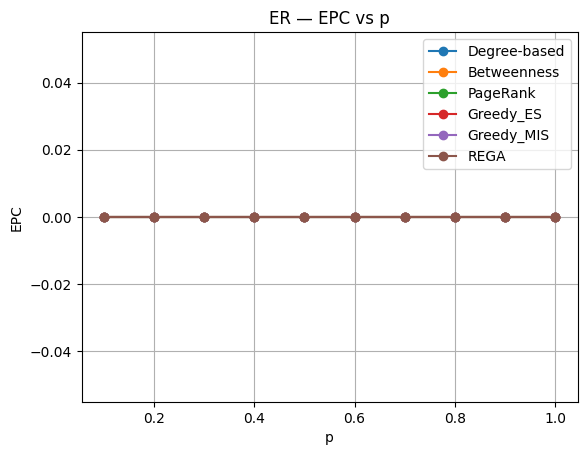

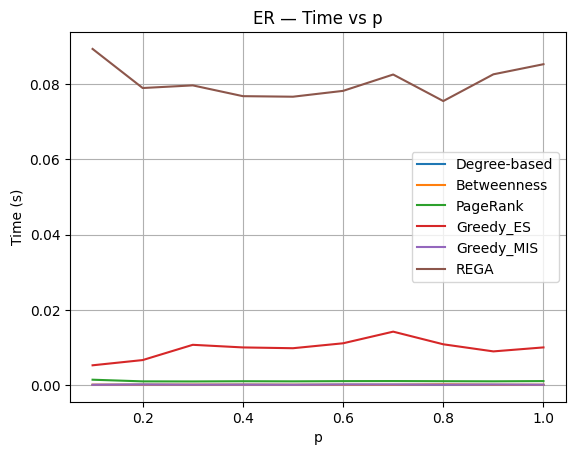

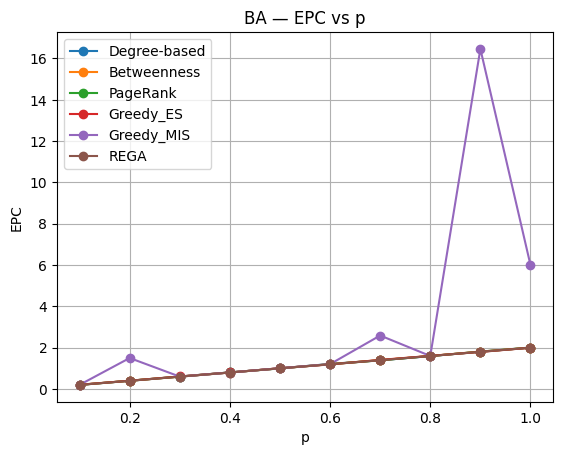

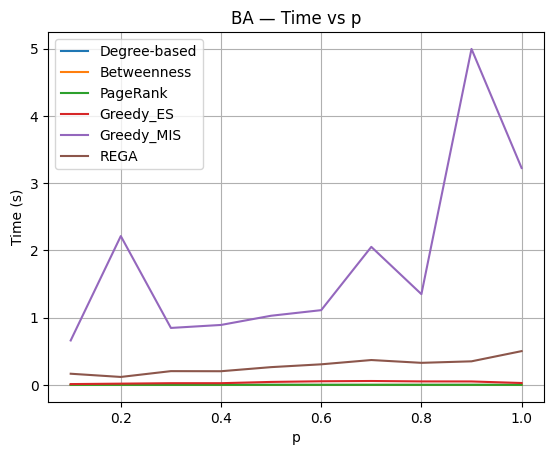

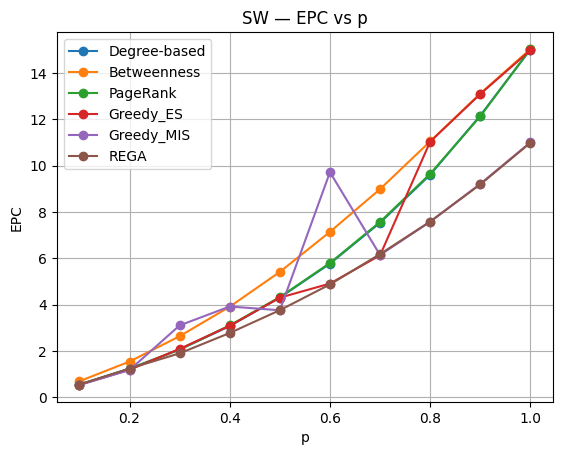

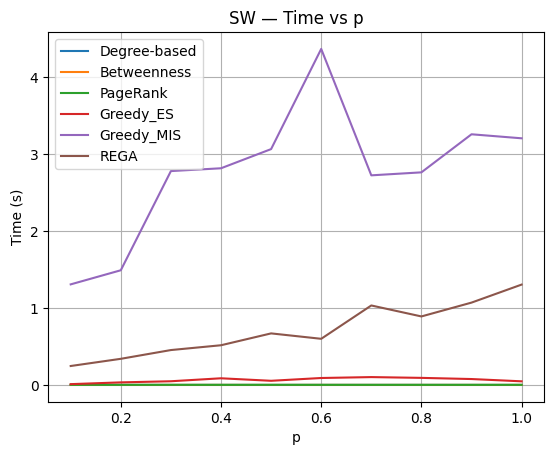

In [ ]:
for name in graph_models:
    plt.figure()
    for algo in df.algo.unique():
        sub=df[(df.model==name)&(df.algo==algo)]
        plt.plot(sub.p, sub.epc, marker='o', label=algo)
    plt.title(f"{name} — EPC vs p")
    plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()

    # plt.savefig(f"{name}_time_vs_p.png")
    
    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.time, label=algo)
    plt.title(f"{name} — Time vs p")
    plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
    # plt.savefig(f"{name}_time_vs_p.png")


plt.show()